<a href="https://colab.research.google.com/github/roszcz/ecg-sonification-demo/blob/master/ecg_intro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ECG Sonification Demo

## Dependencies

Download a data sample from the Physionet Database and install packages for ECG signal handling and MIDI processing.

In [ ]:
# ECG data
!mkdir -p ecg-data
!wget https://physionet.org/files/ltafdb/1.0.0/23.dat -P ecg-data/
!wget https://physionet.org/files/ltafdb/1.0.0/23.hea -P ecg-data/
!wget https://physionet.org/files/ltafdb/1.0.0/23.atr -P ecg-data/

# Download the MIDI sound font
!wget https://cdn.filestackcontent.com/security=p:eyJjYWxsIjogWyJyZWFkIl0sICJleHBpcnkiOiAyNTI5NDgwMDI0MDAsICJoYW5kbGUiOiAiaG9ITW1tZ05UVzJkTk90QjBKREYifQ==,s:6d09c919f9ddd5f4cdc8166bc04001e9428b215c03e017641a825549b6c40150/hoHMmmgNTW2dNOtB0JDF -O GeneralUser_GS_v1.471.sf2

# Python libs
!pip install pretty-midi==0.2.9 midi2audio==0.1.1 wfdb==3.4.0 tqdm

# MIDI Synth
!apt-get install fluidsynth

In [2]:
# Initialize the MIDI synth
import pretty_midi
from midi2audio import FluidSynth
synth = FluidSynth(sound_font='GeneralUser_GS_v1.471.sf2')

## Load ECG signal and labels

Read the ECG signal as `numpy.array` and annotations as `pandas.DataFrame`


In [3]:
import wfdb
import numpy as np
import pandas as pd

record_path = 'ecg-data/23'
ann = wfdb.rdann(record_path, 'atr')
signals, fields = wfdb.rdsamp(record_path)

# `symbol` is the label class, `sample` is the index for the signals array
df = pd.DataFrame({'symbol': ann.symbol, 'aux': ann.aux_note, 'position': ann.sample})

fs = fields['fs']
print('ECG signal size:', signals.shape)
print('ECG sampling rate:', fs, '[Hz]')
print('Labels distribution:', df.symbol.value_counts())

ECG signal size: (11819520, 2)
ECG sampling rate: 128 [Hz]
Labels distribution: N    81870
A    15677
+     2537
V     2407
"        3
Name: symbol, dtype: int64


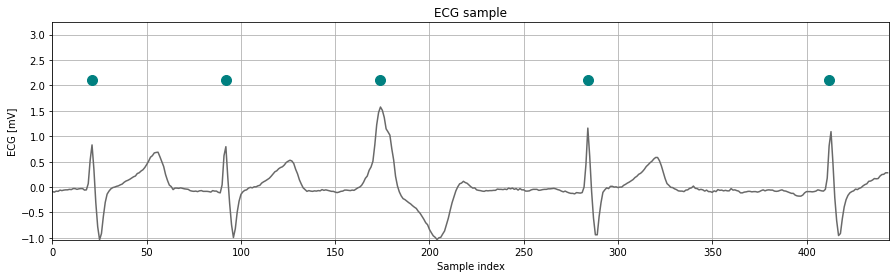

In [4]:
from matplotlib import pyplot as plt

# Representative sample of the raw signal ...
start = 7190174
end = 7190618
signal_part  = signals[start: end, 0]

plt.figure(figsize=[15, 4])
plt.plot(signal_part, color='dimgray')

# ... and corresponding annotations
ids = (df.position > start) & (df.position < end)
df_part = df[ids]

# Shift positions of the sample beats to match the signal fragment
annotation_xs = df_part.position - start
annotation_ys = np.ones_like(annotation_xs) * 2.1
plt.plot(annotation_xs, annotation_ys, 'o', color='teal', ms=10)
plt.grid()
plt.xlabel('Sample index')
plt.ylabel('ECG [mV]')
plt.title('ECG sample')
plt.xlim(0, len(signal_part))
plt.ylim(signal_part.min(), signal_part.max() + 1.666)
plt.show()

## Simple Sonification Sample

Create a basic sonification out of a short fragment of ECG signal

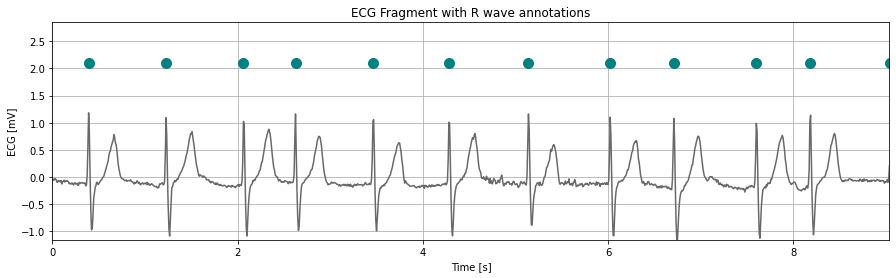

In [5]:
# Take a copy of 12 QRS section from the middle of the signal
part = df[1000:1012].reset_index()

# Get the raw ECG signal, offset to start before the R wave
signal_start = part.position.min() - 50
signal_end = part.position.max()
signal_part = signals[signal_start: signal_end, 0]
times = np.arange(0, len(signal_part)) / fs

# `position` is sample index - let's change it to time, starting at zero
part['start_time'] = (part.position - signal_start) / fs

# Release each note when the next one starts
part['end_time'] = part.start_time.shift(-1)
part.loc[part.index[-1], 'end_time'] = 10

plt.figure(figsize=[15, 4])
plt.plot(times, signal_part, color='dimgray')
plt.xlim(times[0], times[-1])

qrs_y = np.ones(len(part)) * 2.1
plt.plot(part.start_time, qrs_y, 'o', color='teal', ms=10)
plt.grid()
plt.xlabel('Time [s]')
plt.ylabel('ECG [mV]')
plt.ylim(signal_part.min(), signal_part.max() + 1.666)
plt.title('ECG Fragment with R wave annotations');

In [7]:
track = pretty_midi.PrettyMIDI()
piano = pretty_midi.Instrument(program=0, name='piano')
  
for it, row in part.iterrows():
    note = pretty_midi.Note(
        velocity=90,
        pitch=60 + it,
        start=row.start_time,
        end=row.end_time
    )
    piano.notes.append(note)
track.instruments.append(piano)

midi_path = 'track.mid'
wav_path = 'track.wav'
track.write(midi_path)
synth.midi_to_audio(midi_path, wav_path)

In [ ]:
from IPython.display import Audio, display
display(Audio(wav_path, autoplay=True))

In [8]:
!mkdir -p animation

In [ ]:
from tqdm import tqdm

duration = part.iloc[-1].end_time
framerate = 30
frame_count = int(framerate * duration)

plt.figure(figsize=[12, 4])
for frame_id in tqdm(range(frame_count)):
    savepath = f'animation/{1000000 + frame_id}.png'
    signal_idx = frame_id * fs / framerate
    signal_end = round(signal_idx)
    ids = part.start_time <= frame_id * framerate
    visible_qrs = part[ids]
    y = np.ones_like(visible_qrs) * 2.1
    plt.plot(visible_qrs.start_time, y, 'o', color='teal', ms=10)
    plt.plot(times[:signal_end], signal_part[:signal_end], color='dimgray')
    plt.xlim(times[0], times[-1])
    plt.grid()
    plt.xlabel('Time [s]')
    plt.ylabel('ECG [mV]')
    plt.ylim(signal_part.min(), signal_part.max() + 1.666)
    plt.tight_layout()
    plt.savefig(savepath)
    plt.clf()

In [16]:
%%capture
command = """
    ffmpeg \
    -y -framerate 30 -f image2 -pattern_type glob -i 'animation/*png' -i \
    'track.wav' -map 0:v:0 -map 1:a:0 -c:v libx264 -r 30 -profile:v high -crf 20 -pix_fmt yuv420p colab.mp4
"""
!$command

In [ ]:
from IPython.display import HTML
from base64 import b64encode

mp4 = open('colab.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=800 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)